# Multilingual emoji prediction project

Import tools

In [1]:
import os
import pandas as pd
import sklearn
import json
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
from keras.engine.saving import load_model, model_from_json
from numpy import argmax
import scipy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Load the proprocessed data 

In [2]:
NAME_OF_MODEL_FOR_NN = "Models/model20w2v3.h5"

In [3]:
os.makedirs(os.path.dirname("Models/"), exist_ok=True)

PreprocessedDataFolder = "PreprocessedData"
trainFile = PreprocessedDataFolder+"/train.prepro"
testFile = PreprocessedDataFolder+"/test.prepro"
HistoryFolder = "History"


preprocessed_data = []
with open(trainFile, 'r', encoding="utf_8") as f:
    preprocessed_data = [s.rstrip() for s in f.readlines()]

pd.DataFrame(preprocessed_data[:3])



0
0  umm welcom goldman hous chao sometim take
1            long point trail new river gorg
2        littl bit everyth lot noth bro agre

In [4]:
%%time
preprocessed_data_test = []
with open(testFile, 'r', encoding="utf_8") as f:
    preprocessed_data_test = [s.rstrip() for s in f.readlines()]

pd.DataFrame(preprocessed_data_test[:3])

Wall time: 68 ms


0
0  beef heart tartar fish sauc chili puf rice radish
1  sometim go stand outsid someon ask us peopl sa...
2  good night nation capit washington district co...

In [5]:
len(preprocessed_data)

388577

In [6]:
len(preprocessed_data_test)

97145

In [7]:
trainFile = PreprocessedDataFolder+"/train.emojis"
testFile = PreprocessedDataFolder+"/test.emojis"
y_train_full = []
with open(trainFile, 'r', encoding="utf_8") as f:
    y_train_full = [int(s.rstrip()) for s in f.readlines()]

In [8]:
y_test = []
with open(testFile, 'r', encoding="utf_8") as f:
    y_test = [int(s.rstrip()) for s in f.readlines()]

# Representation

#### building Word2vec

In [9]:
import gensim
import nltk
from gensim.utils import tokenize

In [10]:
tweet_train = [list(tokenize(s, deacc=True, lower=True)) for s in preprocessed_data]
tweet_test = [list(tokenize(s, deacc=True, lower=True)) for s in preprocessed_data_test]

In [11]:
tweet_test[:5]

[['beef', 'heart', 'tartar', 'fish', 'sauc', 'chili', 'puf', 'rice', 'radish'],
 ['sometim',
  'go',
  'stand',
  'outsid',
  'someon',
  'ask',
  'us',
  'peopl',
  'say',
  're',
  'outstand'],
 ['good', 'night', 'nation', 'capit', 'washington', 'district', 'columbia'],
 ['regret', 'enjoy', 'life'],
 ['makeup',
  'hair',
  'amaz',
  'woman',
  'elisasgaragehairstudio',
  'yesterday',
  's',
  'set']]

In [12]:
from gensim.models import word2vec

train our proper w2vec

In [13]:
# %%time
# modelw2v = word2vec.Word2Vec(tweet_train, size=300, window=20,
#                           min_count=2, workers=7, iter=100)#very long
# modelw2v.corpus_count
# 

In [14]:
# modelw2v.save('Models/trained_word2vec300.bin')

Use an existing w2vec

In [15]:
%%time
modelw2v = gensim.models.KeyedVectors.load_word2vec_format('Models/glove.twitter.27B.100d.txt', binary=False)

Wall time: 2min 25s


In [16]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase) if len(phrase)!=0 else np.zeros((model.vector_size,))

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats

In [17]:
modelw2v.most_similar("christmas")

[('xmas', 0.8936437368392944),
 ('holiday', 0.844959557056427),
 ('merry', 0.8192397356033325),
 ('valentines', 0.8156405687332153),
 ('easter', 0.813959002494812),
 ('holidays', 0.811529278755188),
 ('day', 0.7869322299957275),
 ('valentine', 0.7727159857749939),
 ('thanksgiving', 0.765180230140686),
 ('year', 0.7584649324417114)]

In [18]:
%%time
train_dtm = word2vec_features(tweet_train, modelw2v)
train_dtm.shape

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 14.4 s


(388577, 100)

In [19]:
test_dtm = word2vec_features(tweet_test, modelw2v)
test_dtm.shape

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(97145, 100)

# Classification

define tools functions to help evaluate simple classifiers

In [20]:
#cell inspired from https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost/index.html
outputFile = "Log/log.txt"
os.makedirs(os.path.dirname(outputFile), exist_ok=True)

import datetime
def log(x):
    #can be used to write to log file
    print(x)
    out_data = open(outputFile, 'a', encoding="utf_8")
    out_data.write(x)
    out_data.close()
    
from time import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, \
    classification_report
def test_classifier(X_train, y_train, X_test, y_test, classifier,classLabels,evalName=""):
    logstr = ""
    logstr += "===============================================\n"
    logstr += "WORD2VEC pretrained 100d\n"
    logstr += str(datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y"))+"\n"
    classifier_name = str(type(classifier).__name__)
    logstr += "Testing " + classifier_name+"\n"
    now = time()
    #list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    logstr += "Learing time {0}s".format(time() - now)+"\n"
    now = time()
    predictions = model.predict(X_test)
    logstr += "Predicting time {0}s".format(time() - now)+"\n"
    log(logstr)
    return evaluateClassif(predictions,y_test,classLabels,evalName)
def evaluateClassif(predictions,y_test,classLabels,evalName):
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    logstr="\n"
    logstr += "=================== Results ==================="+"\n"
    logstr += "WORD2VEC prentrained 100d\n"
    logstr += evalName+"\n"
    logstr += "         "+"    ".join(str(c)+(3-len(str(c)))*" " for c in classLabels)+"\n"
    logstr += "F1       " + "   ".join(["%.2f" % f for f in f1])+"\n"+"\n"
    logstr += "Precision" + "   ".join(["%.2f" % f  for f in precision])+"\n"
    logstr += "Recall   " + "   ".join(["%.2f" % f  for f in recall] )+"\n"
    logstr += "Confusion Matrix : \n"
    confus = confusion_matrix(predictions,y_test)
    for l in confus:
        logstr+=" ".join([str(f)+(5-len(str(f)))*" " for f in l])+"\n"
    logstr += "Accuracy " + str(accuracy)+"\n"
    #logstr += "F1 mean : " + str(f1_score(y_test, predictions, average="micro"))+"\n"
    logstr += "==============================================="+"\n"
    logstr += "==============================================="+"\n"
    log(logstr)
    return precision, recall, accuracy, f1

In [21]:
labels = [str(i) for i in range(20)]

In [23]:
#predict only heart
#Due to the (very) non uniform distribution, especially for heart,
#we obtain a accuracy score of 21% by predicting only heart
prediction = [0 for i in range(len(y_test))]
scores = evaluateClassif(prediction,y_test,labels,"only Heart")

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



=================== Results ===================
WORD2VEC prentrained 100d
only Heart
         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.58   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.41   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   1.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
21016 10240 10132 5171  4797 
0     0     0     0     0    
0     0     0     0     0    
0     0     0     0     0    
0     0     0     0     0    
Accuracy 0.4092219020172911



#### Naives bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [24]:
%%time
precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, BernoulliNB(),labels)

WORD2VEC pretrained 100d
12:18AM on October 29, 2019
Testing BernoulliNB
Learing time 1.0329744815826416s
Predicting time 0.2069997787475586s


=================== Results ===================
WORD2VEC prentrained 100d

         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.49   0.11   0.13   0.33   0.24   0.06   0.04   0.12   0.15   0.18   0.01   0.04   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.46   0.26   0.17   0.25   0.21   0.11   0.09   0.16   0.10   0.12   0.05   0.16   0.06   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.53   0.07   0.10   0.49   0.26   0.04   0.03   0.09   0.33   0.42   0.00   0.02   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
16842 5932  1698  2227  1011  1871  1124  1298  923   669   844   693   855   676  
1055  887   191   249   180   173   102   133   55    56    123   42    101   114  
809  

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [25]:
%%time
#cant do becase have some negative
#precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, MultinomialNB(),labels)

Wall time: 0 ns


#### Logistic regression

In [26]:
%%time
from sklearn.linear_model import LogisticRegression
precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, LogisticRegression(),labels)

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sk

WORD2VEC pretrained 100d
12:18AM on October 29, 2019
Testing LogisticRegression
Learing time 317.61190533638s
Predicting time 0.04399919509887695s


=================== Results ===================
WORD2VEC prentrained 100d

         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.54   0.06   0.11   0.36   0.30   0.00   0.01   0.06   0.14   0.19   0.00   0.05   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.38   0.28   0.30   0.36   0.40   0.11   0.21   0.35   0.42   0.33   0.24   0.36   0.20   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.92   0.04   0.07   0.35   0.23   0.00   0.01   0.03   0.08   0.14   0.00   0.02   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
29427 11552 4408  5930  2903  3868  3236  2913  2510  2064  2003  1888  2022  1728 
389   472   94    130   111   85    64    74    19    30    75    25    71    75   


#### Neural networks

Add other features

In [22]:
from scipy.sparse import hstack, csr_matrix

class FeatureAdder: 
    def __init__(self,train : bool):
        if train : 
            self.file = PreprocessedDataFolder+"/train.addFeatures"
        else : 
            self.file = PreprocessedDataFolder+"/test.addFeatures"

    #data : in out
    def addAllFeatures(self, features : csr_matrix):
        tmp = csr_matrix( pd.read_csv(self.file).iloc[:,1:].values)
        return hstack((features,tmp))

In [23]:
%%time
oldNb = train_dtm.shape[1]
featAdder = FeatureAdder(True)
train_dtm = featAdder.addAllFeatures(train_dtm)
train_dtm.shape[1]-oldNb 

Wall time: 2.24 s


7

In [24]:
%%time
featAdder = FeatureAdder(False)
test_dtm = featAdder.addAllFeatures(test_dtm)

Wall time: 591 ms


Creation of our validation set from the training set

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train_dtm, y_train_full, test_size=0.15, random_state=44)

Binarize our output to do categorical neural network (become a vector, with a 1 in the column of the corresponding output(index)).   

In [26]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
y_train_binary[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]], dtype=float32)

In [27]:
#helped from https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/
from keras.models import Sequential
from keras.layers import Dense,Dropout,TimeDistributed,LSTM
from keras.callbacks import EarlyStopping


model = Sequential()

In [28]:
train_dtm.shape

(388577, 107)

In [29]:
len(y_train_binary[0])

20

In [30]:
model.add(Dense(1200, input_dim=train_dtm.shape[1], activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train_binary[0]), activation='sigmoid'))

In [30]:
#if already a model learned
if os.path.isfile(NAME_OF_MODEL_FOR_NN):
    model = load_model(NAME_OF_MODEL_FOR_NN)

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
EPOCHS = 400


Define the callback list :
* Early stopping to stop when the loss of the validation set do not improve during 50 epochs
* a ModelCheckpoint, to save the best model

In [33]:
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=15)
filepath = NAME_OF_MODEL_FOR_NN
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')#will save if the val_loss is lower
callbacks_list = [es,checkpoint]

In [34]:
%%time
H = model.fit(X_train, y_train_binary,batch_size=300, epochs=EPOCHS, max_queue_size=20,validation_data=(X_valid, y_valid_binary),callbacks=callbacks_list,use_multiprocessing=True, workers=7,verbose = 2)

Train on 313355 samples, validate on 55299 samples
Epoch 1/400
 - 12s - loss: 2.0436 - accuracy: 0.3563 - val_loss: 1.9566 - val_accuracy: 0.3874

Epoch 00001: val_accuracy improved from -inf to 0.38738, saving model to Models/modelSemanticw2v3.h5
Epoch 2/400
 - 12s - loss: 1.9317 - accuracy: 0.3923 - val_loss: 1.9005 - val_accuracy: 0.4019

Epoch 00002: val_accuracy improved from 0.38738 to 0.40185, saving model to Models/modelSemanticw2v3.h5
Epoch 3/400
 - 12s - loss: 1.8897 - accuracy: 0.4037 - val_loss: 1.8709 - val_accuracy: 0.4097

Epoch 00003: val_accuracy improved from 0.40185 to 0.40970, saving model to Models/modelSemanticw2v3.h5
Epoch 4/400
 - 12s - loss: 1.8635 - accuracy: 0.4109 - val_loss: 1.8623 - val_accuracy: 0.4123

Epoch 00004: val_accuracy improved from 0.40970 to 0.41232, saving model to Models/modelSemanticw2v3.h5
Epoch 5/400
 - 12s - loss: 1.8409 - accuracy: 0.4170 - val_loss: 1.8412 - val_accuracy: 0.4153

Epoch 00005: val_accuracy improved from 0.41232 to 0.415

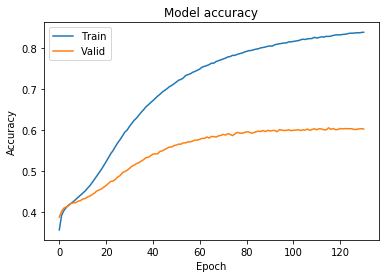

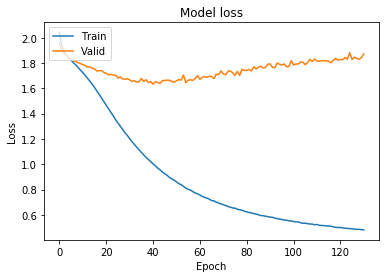

In [35]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

save model history

In [36]:
import pickle

In [37]:
file = HistoryFolder + "/trainHistoryDict"+NAME_OF_MODEL_FOR_NN+"optiAcc.hist"
os.makedirs(os.path.dirname(file), exist_ok=True)

with open(file, 'wb') as file_pi:
    pickle.dump(H.history, file_pi)
    

Evaluate our best model

In [38]:
model = load_model(NAME_OF_MODEL_FOR_NN)

In [32]:
res = model.predict(test_dtm.todense())#warning, use a lot of memory (+10/12Go)

In [33]:
predict = [argmax(r) for r in res]#put in a single number (it was binarize, one hot encoding)

In [34]:
scores = evaluateClassif(predict, y_test ,labels,"NN 20 w2v p 100d optiAcc "+NAME_OF_MODEL_FOR_NN)


=================== Results ===================
WORD2VEC prentrained 100d
NN 20 w2v p 100d optiAcc Models/model20w2v3.h5
         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.57   0.50   0.58   0.49   0.59   0.48   0.47   0.51   0.48   0.48   0.51   0.60   0.57   0.51   0.46   0.50   0.48   0.71   0.50   0.47

Precision0.49   0.49   0.54   0.60   0.61   0.55   0.52   0.56   0.58   0.61   0.55   0.64   0.58   0.65   0.53   0.54   0.59   0.71   0.54   0.58
Recall   0.69   0.51   0.64   0.42   0.57   0.42   0.42   0.46   0.41   0.40   0.47   0.56   0.57   0.42   0.41   0.46   0.41   0.71   0.46   0.39
Confusion Matrix : 
14565 2435  1313  1648  593   1074  736   726   949   905   558   584   428   761   515   461   482   342   430   431  
1507  5149  524   312   243   330   298   273   215   211   197   126   142   148   174   129   212   71    135   166  
948   650   6432  214   372   

#### SVM

In [27]:
X_train_small, _, y_train_small, _ = train_test_split(train_dtm, y_train_full, test_size=0.75, random_state=88)

In [28]:
%%time
from sklearn import svm
from sklearn.model_selection import GridSearchCV

Wall time: 0 ns


In [29]:
%%time
parameters = {'C':[8.5,9.5],'gamma':[0.001, 0.1]}
svc = svm.SVC(kernel="rbf")
clf = GridSearchCV(svc, parameters, cv=3,verbose=15,n_jobs=8,refit=False)#cv for cross validation
clf.fit(X_train_small, y_train_small,)#take only 1/4 of full data to estime first parameters

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Wall time: 3h 18min 7s


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 48.4min
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed: 48.6min remaining: 242.9min
[Parallel(n_jobs=8)]: Done   3 out of  12 | elapsed: 50.6min remaining: 151.8min
[Parallel(n_jobs=8)]: Done   4 out of  12 | elapsed: 51.7min remaining: 103.5min
[Parallel(n_jobs=8)]: Done   5 out of  12 | elapsed: 52.3min remaining: 73.2min
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed: 94.9min remaining: 94.9min
[Parallel(n_jobs=8)]: Done   7 out of  12 | elapsed: 176.6min remaining: 126.1min
[Parallel(n_jobs=8)]: Done   8 out of  12 | elapsed: 177.1min remaining: 88.5min
[Parallel(n_jobs=8)]: Done   9 out of  12 | elapsed: 178.7min remaining: 59.6min
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed: 196.3min remaining: 39.3min
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 198.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 19

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=8,
             param_grid={'C': [8.5, 9.5], 'gamma': [0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=None, verbose=15)

In [30]:
clf.cv_results_['mean_test_score']

array([0.51186837, 0.46766624, 0.51247201, 0.46772466])

In [31]:
clf.best_params_

{'C': 9.5, 'gamma': 0.001}

In [32]:
file = "BestParams/SVM5.params"
os.makedirs(os.path.dirname(file), exist_ok=True)

with open(file, 'w') as file_pi:
    file_pi.write(str(clf.best_params_))

In [33]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

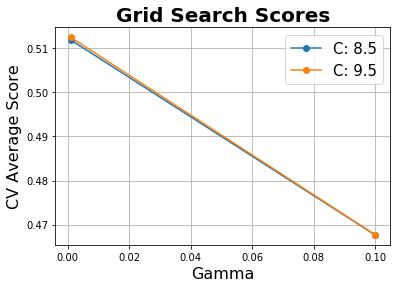

In [35]:
#Function from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(clf.cv_results_, [0.001, 0.1], [8.5,9.5], 'Gamma', 'C')

In [ ]:
prdictionsSvm = clf.predict(test_dtm)

In [ ]:
scores = evaluateClassif(prdictionsSvm,y_test,labels,"SMV5 tuned, not on all data 40%train")

In [ ]:
from sklearn.externals import joblib

In [ ]:
file = "Models/SVM5Partial.model"
os.makedirs(os.path.dirname(file), exist_ok=True)
joblib.dump(clf,file)

In [ ]:
1+1

learn on all the data with tuned params


In [ ]:
%%time
svc = svm.SVC(kernel="rbf",C=9.5,gamma=0.001)
svc.fit(train_dtm,y_train_full)#take full train data

In [ ]:
prdictionsSvm = svc.predict(test_dtm)
scores = evaluateClassif(prdictionsSvm,y_test,labels,"SMV5 W2v")

try linear kernel


In [36]:
from sklearn.svm import LinearSVC
linSvc = LinearSVC()
linSvc.fit(train_dtm,y_train_full)

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [38]:
prdictionsSvm = linSvc.predict(test_dtm)
scores = evaluateClassif(prdictionsSvm,y_test,labels,"SMV5 linear W2v")


d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



=================== Results ===================
WORD2VEC prentrained 100d
SMV5 linear W2v
         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.57   0.16   0.50   0.13   0.37   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.51   0.36   0.46   0.19   0.31   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.64   0.10   0.56   0.10   0.45   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
13461 5587  2715  3122  1505 
1097  1059  369   273   177  
3013  1939  5647  781   868  
1432  454   227   516   67   
2013  1201  1174  479   2180 
Accuracy 0.44518654100786664

